In [3]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import preamble
from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED
from src.dim_reduction import display_axis_semantics, closest_words_for_pc, get_extreme_examples, get_aggregated_embeddings_for_each_year

In [5]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
print(f"#Samples: {len(df)}")

#Samples: 9705


In [6]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

# Partial least squares regression

Identify component in our embeddings which explain our target variable (party affiliation)

In [271]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, 'block')

In [272]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

X = np.stack(df[EMBEDDING_MODEL])


lb = LabelEncoder()
y = lb.fit_transform(df["block"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

print(f"#Classes {len(lb.classes_)}")

y = np.eye(len(lb.classes_))[y_train]  # create one-hot encodding to use PLS for classification PLS-DA


pls = PLSRegression(n_components=2)
pls.fit(X_train, y)

reduced = pls.transform(X)

print(f"PLS r-squared {pls.score(X_test, np.eye(len(lb.classes_))[y_test]):.3f}")


#Classes 6
PLS r-squared 0.105


## Plotting Results

In [273]:
def plot_aggregated_yearly_data(aggregated: pd.DataFrame, reduced_embeddings: np.array, target_var: str, color_map: dict, ax):
  ax.set_title("Two Dimensional Projection of Political Groups")

  grt = np.abs(reduced_embeddings).max() * 1.1

  ax.set_xlim(-grt, grt)
  ax.set_ylim(-grt, grt)

  scale = grt * 2


  for party in aggregated[target_var].unique():
      party_mask = aggregated[target_var] == party
      years = aggregated[party_mask]['year']
      party_embeddings = reduced_embeddings[party_mask]
      
      ax.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party], label=party)
      for i, year in enumerate(years):
        ax.text(party_embeddings[i,0] - scale * 0.01, party_embeddings[i,1]+ scale * 0.015, f"{year}",
                  fontsize=8, bbox=dict(boxstyle="round", color=color_map[party], alpha=0.7), 
                  color='white',
                  )

  ax.axhline(0, linestyle="--")
  ax.axvline(0, linestyle="--")
  ax.grid()
  ax.legend(loc="upper left")
  return ax

In [274]:
def plot_pca_axis_development(axis: int, aggregated: pd.DataFrame,  target_var: str, reduced_embeddings: np.array, 
                              axis_labels: tuple[list[str]], color_map: dict, ax: plt.Axes,
                              top_k: int = 3):

    ax.set_title(f"Development of parties over the years accross reduced-axis {axis}")

    for party in aggregated[target_var].unique():
        party_mask = aggregated[target_var] == party
        years = aggregated[party_mask]['year']
        party_embeddings = reduced_embeddings[party_mask]
        ax.plot(years,  party_embeddings[:, axis], marker='o', color=color_map[party])

    
    max_y_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

    ax.set_ylim((-max_y_lim, max_y_lim))  
    ax.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], axis_labels[0][:top_k]))
    ax_label_pos = ', '.join(map(lambda x: x[0], axis_labels[1][:top_k]))

    props = dict(boxstyle='round', facecolor="grey", alpha=0.5)

    # label for negative axis: 
    ax.text(2014, -0.8 * max_y_lim , f"{ax_label_neg}", horizontalalignment="left", bbox=props)
    # label for positive axis: 
    ax.text(2014, 0.8 * max_y_lim, f"{ax_label_pos}", horizontalalignment="left", bbox=props)
    ax.grid()
    # ax.legend(loc="lower left")


In [275]:
def display_results(model, axis: tuple[int], aggregated: pd.DataFrame, vocab_df: pd.DataFrame,
                     reduced_embeddings: np.stack, target_var: str, color_map: dict) -> None:
    
    fig = plt.figure(layout="constrained", figsize=(18, 8))

    gs0 = fig.add_gridspec(1, 2)

    gs1 = gs0[1].subgridspec(2, 1)

    ax1 = fig.add_subplot(gs0[0])
    ax2 = fig.add_subplot(gs1[0])
    ax3 = fig.add_subplot(gs1[1], sharex=ax2)

    axis_labels_0 = closest_words_for_pc(axis[0], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
    axis_labels_1  = closest_words_for_pc(axis[1], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

    display_axis_semantics([(axis_labels_0), 
                            (axis_labels_1)])

    plot_aggregated_yearly_data(aggregated, reduced_embeddings, target_var, color_map, ax1)
    plot_pca_axis_development(0, aggregated, target_var, reduced_embeddings, axis_labels_0, color_map, ax2)
    plot_pca_axis_development(1, aggregated, target_var, reduced_embeddings, axis_labels_1, color_map, ax3)


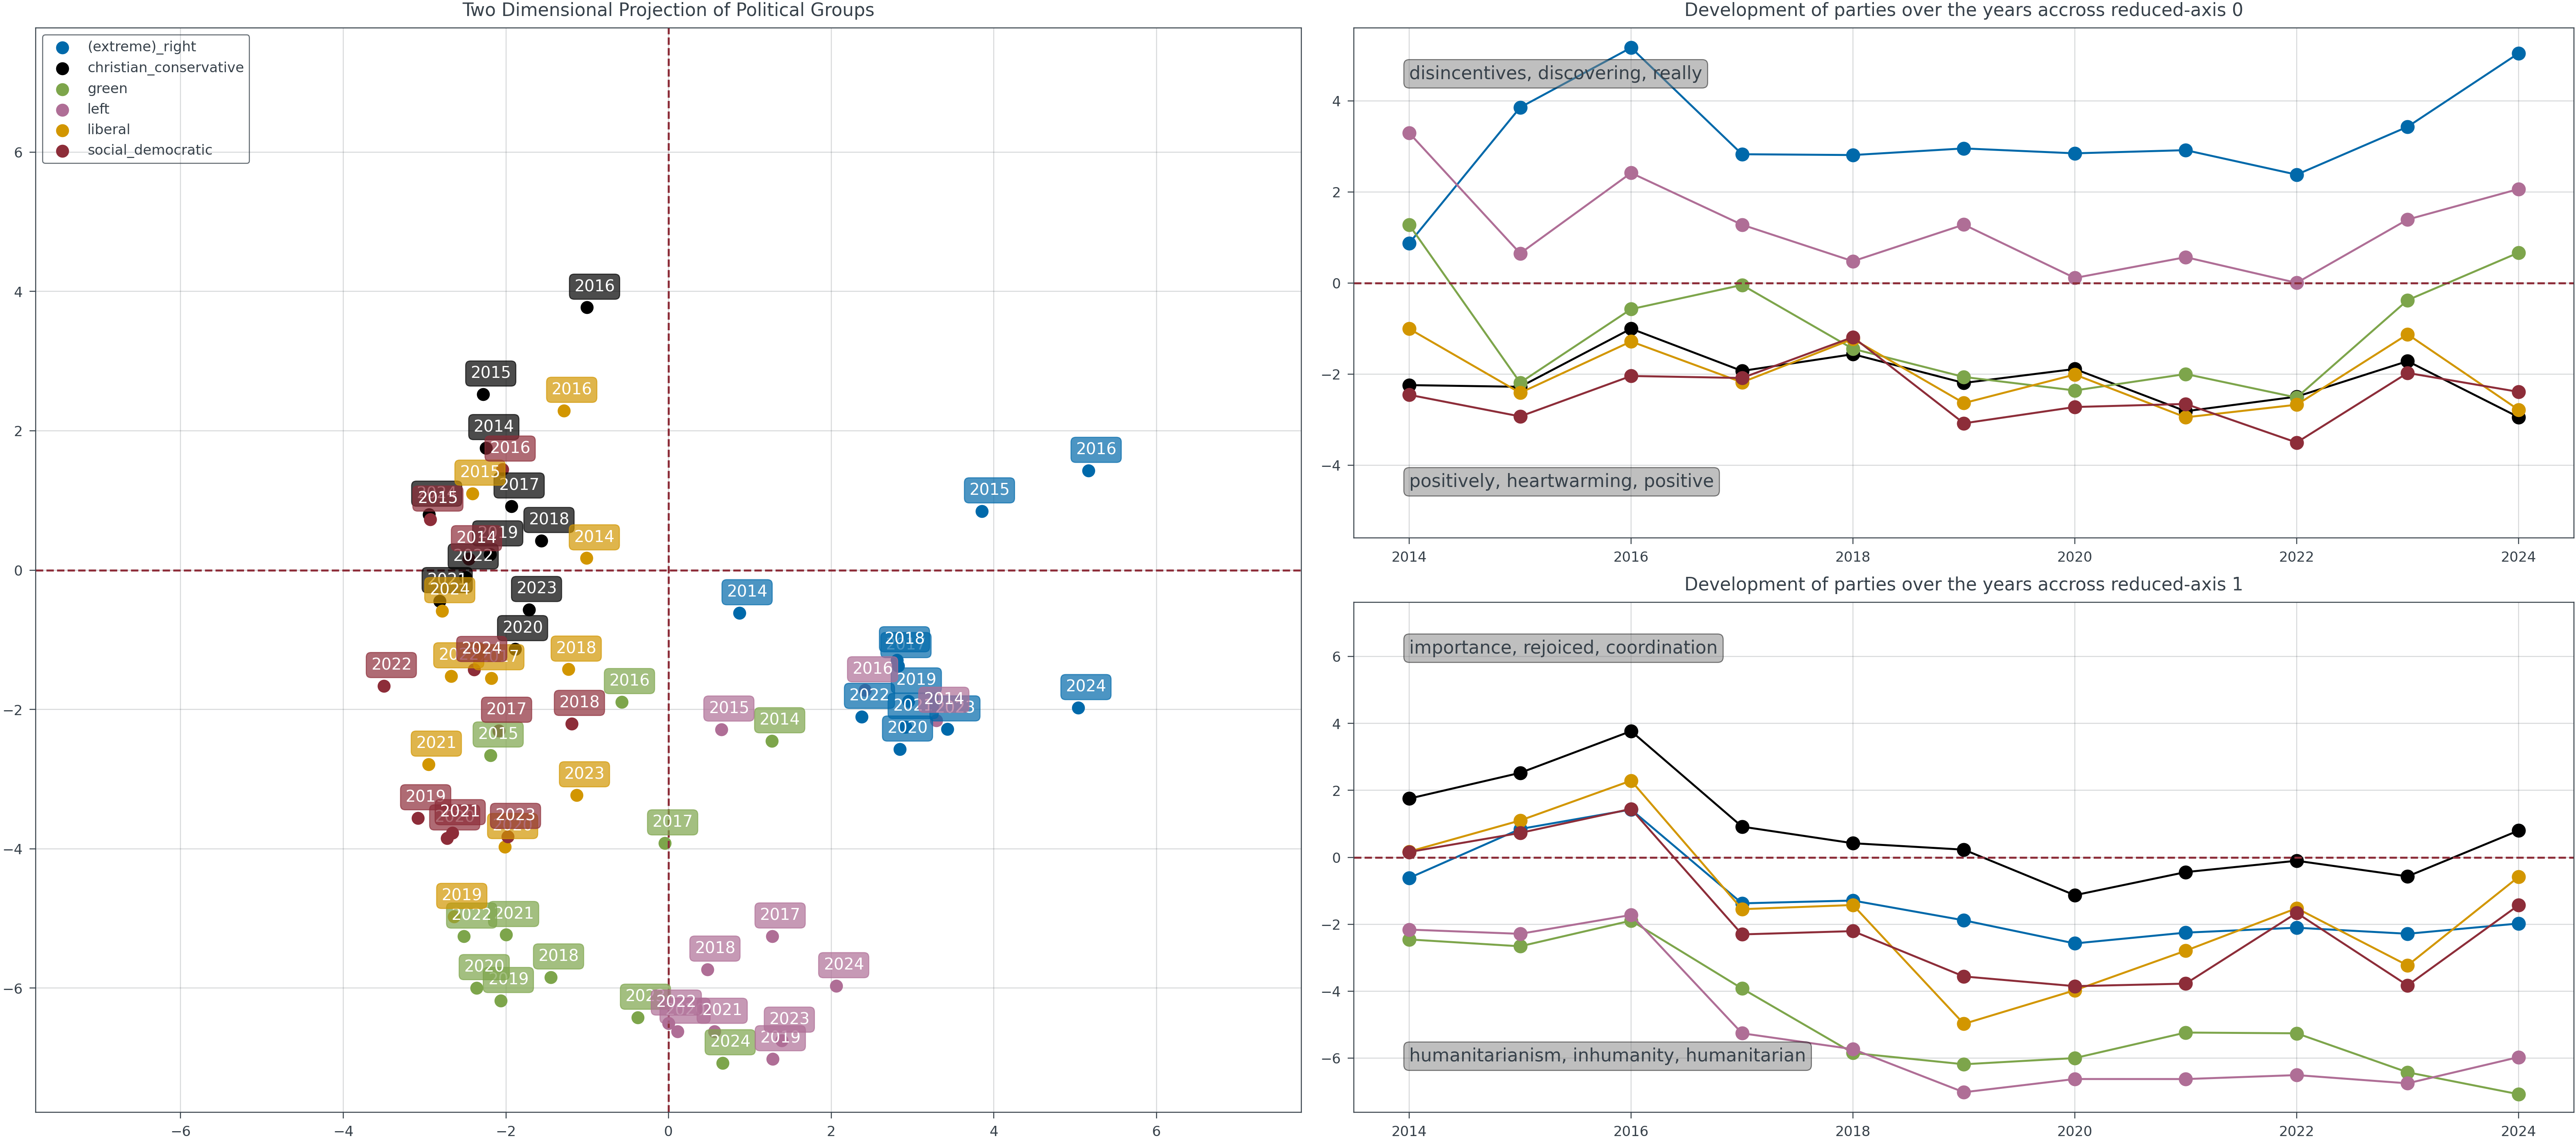

In [276]:
display_results(pls, [0, 1], aggregated, vocab_df, 
                pls.transform(np.stack(aggregated[EMBEDDING_MODEL])), "block", COLOR_MAPS['block'])

In [217]:
reduced = pls.transform(np.stack(df[EMBEDDING_MODEL]))
normalized = reduced / np.linalg.vector_norm(reduced, ord=2, axis=1, keepdims=True)

In [ ]:
def get_top_k_extreme_examples(df: pd.DataFrame, embeddings: np.array, top_k=10):
    sorted_0 = embeddings[:, 0].argsort()
    sorted_1 = embeddings[:, 1].argsort()
    return df.iloc[sorted_0[:top_k]], df.iloc[sorted_0[-top_k:]], df.iloc[sorted_1[:top_k]], df.iloc[sorted_1[-top_k:]]

In [286]:
reduced[:, 0].argsort()

array([ 730, 8254, 4690, ..., 4797, 7537, 6912], shape=(9705,))

In [288]:
df.iloc[6912]['translatedText']

'I voted against this report, because it gives an inappropriate role to migrants.'

In [269]:
import textwrap
left_mask = df['block'] == '(extreme)_right'
neg_0, pos_0, neg_1, pos_1 = get_top_k_extreme_examples(df[left_mask], normalized[left_mask])

In [270]:
for row in pos_1.iloc:
    print(textwrap.fill(row['translatedText']))
    print("=" * 200)

The large amount of legislation of the European Union and the constant
development that requires a quick reaction often means that
legislation that no longer has its application in practice, because
the situation for which it was created has passed, or they have become
obsolete and their role has been taken over by other legislation, are
still formally in force. This can cause legal uncertainty and chaos
when trying to navigate European legislation. That is why I support
the European Commission's REFIT program, in which the Commission
gradually focuses on individual areas of legislation and proposes the
abolition of those that are no longer necessary for the above-
mentioned reasons. Since there have been several of them in the field
of Schengen law, I supported this as well as two other reports on the
abolition of unnecessary legal acts.
One of the European Union's biggest current challenges concerns the
effectiveness of the common European asylum system, which is still too
weak and s

In [ ]:
print(textwrap.fill(pos_0.iloc[0]['translatedText']))

In [ ]:
X = np.stack(df[EMBEDDING_MODEL])


lb = LabelEncoder()

# create one-hot encodding to use PLS for classification PLS-DA

y_block = lb.fit_transform(df["block"])
y_block = np.eye(len(lb.classes_))[y_block]
y_year = lb.fit_transform(df["year"])
y_year = np.eye(len(lb.classes_))[y_year] 

y = np.concat([y_block, y_year], axis=1)


pls = PLSRegression(n_components=2)
pls.fit(X, y)

reduced = pls.transform(X)

# PLS + Clustering
With PLS and our vocab embeddings we can try to find out which 

In [230]:
len(df['party'].unique())

8

In [260]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tqdm import tqdm

X = np.stack(df[EMBEDDING_MODEL])
results = {}

for num_clusters in tqdm(range(len(df['party'].unique()), len(df['party'].unique()) * len(df["year"].unique()) + 1)):

    kmeans = KMeans(n_clusters=num_clusters)
    predicted_clusters = kmeans.fit_predict(X)

    pls = PLSRegression(n_components=2)

    y = np.eye(num_clusters)[predicted_clusters]

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    pls.fit(X_train, y_train)

    results[num_clusters] = pls.score(X_test, y_test)

100%|██████████| 81/81 [02:31<00:00,  1.87s/it]


In [262]:
max(results.items(), key=lambda item: item[1])

(8, 0.2066475127145027)

In [245]:
kmeans = KMeans(n_clusters=8)
predicted_clusters = kmeans.fit_predict(X)
pls = PLSRegression(n_components=2)
pls.fit(X, predicted_clusters)

,n_components,2
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


In [246]:
axis_labels_0 = closest_words_for_pc(0, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

display_axis_semantics([(axis_labels_0), 
                            (axis_labels_1)])

In [247]:
df.groupby(predicted_clusters)['block'].value_counts()

   block                 
0  (extreme)_right           243
   christian_conservative    185
   social_democratic         158
   left                      116
   green                      55
   liberal                    52
1  social_democratic         474
   christian_conservative    391
   (extreme)_right           274
   liberal                   101
   left                       93
   green                      59
2  (extreme)_right           614
   christian_conservative    216
   left                      203
   social_democratic         183
   green                      85
   liberal                    85
3  social_democratic         292
   (extreme)_right           236
   christian_conservative    189
   left                      107
   green                      91
   liberal                    90
4  (extreme)_right           599
   christian_conservative    239
   left                      176
   social_democratic         122
   liberal                    78
   green         

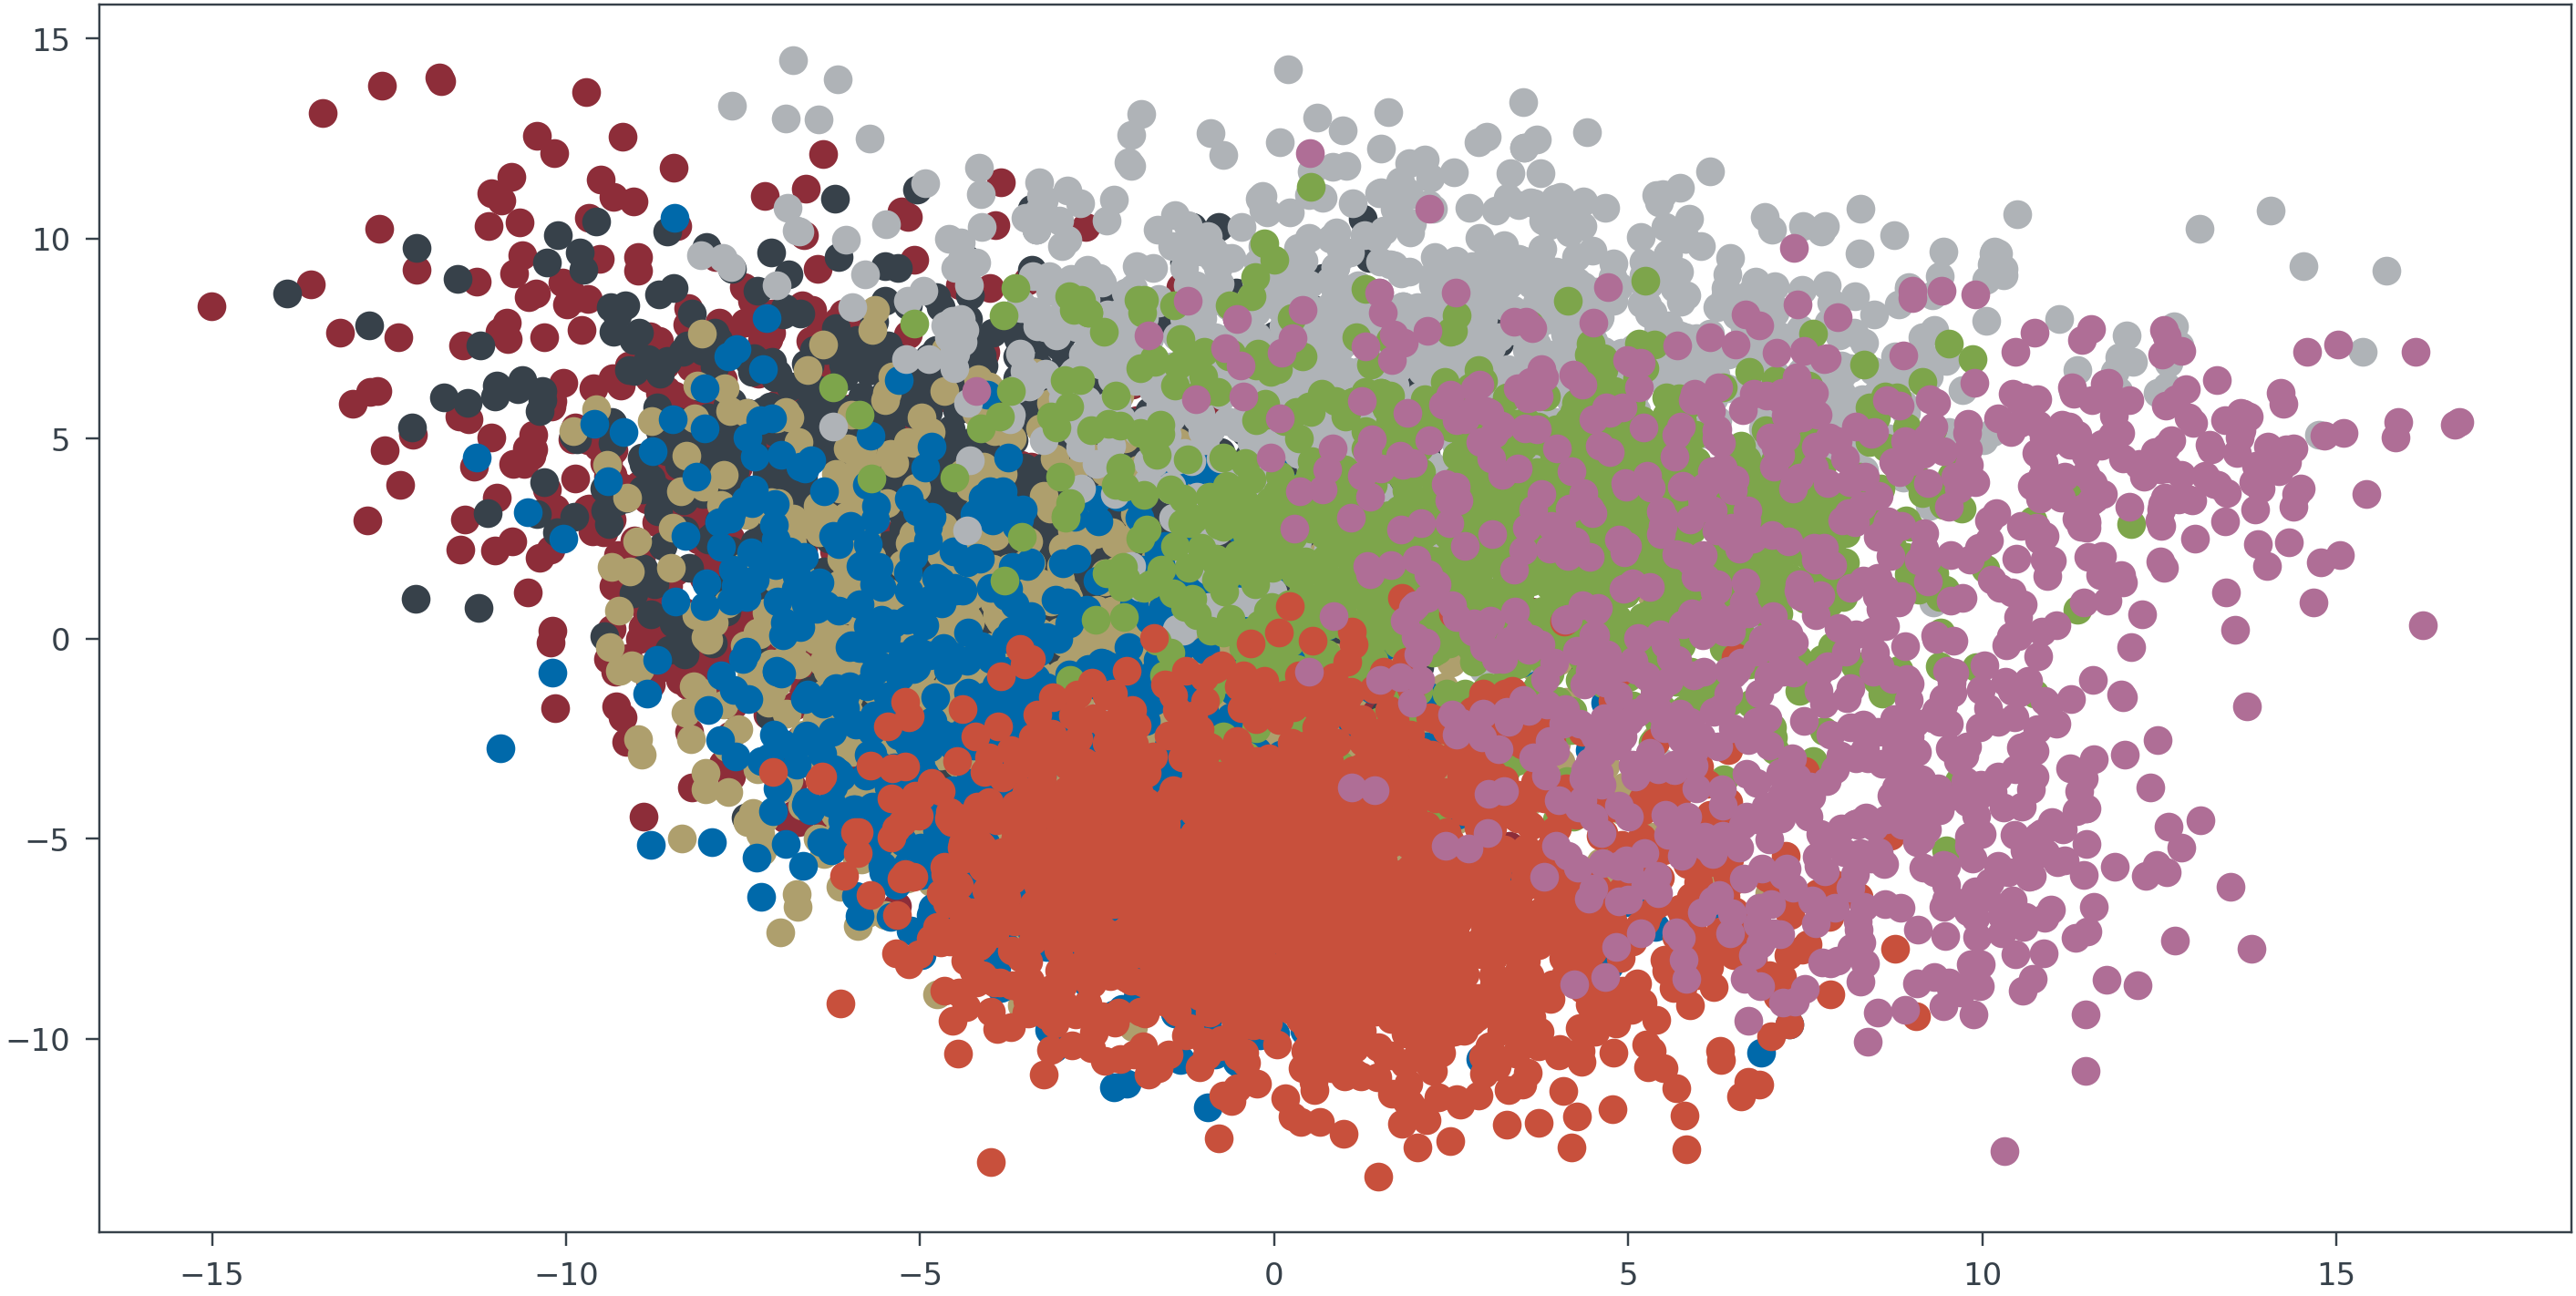

In [250]:
reduced = pls.transform(X)

fig, ax = plt.subplots(figsize=(10, 5))

for cluster_id in range(8):
    mask = predicted_clusters == cluster_id
    ax.scatter(reduced[mask, 0], reduced[mask, 1])